In [1]:
import numpy as np, uproot as ur, awkward as ak, pandas as pd
import matplotlib.pyplot as plt
import os, sys
import pickle
import scipy.stats as st
from collections import defaultdict
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from scipy.stats import poisson, norm
from scipy.spatial import ConvexHull


import mplhep as hep
plt.figure()
hep.style.use("CMS")
plt.close()

def gaus(x, amp, mean, sigma):
    return amp * np.exp( -(x - mean)**2 / (2*sigma**2) ) 

def phi_reconstruct(x, y, z):
    return np.degrees(np.arctan2(y, x))
    
def theta_reconstruct(x, y, z):
    return np.degrees(np.arccos(abs(z)/np.sqrt(x**2+y**2+z**2)))

def phi_reconstruct(x, y, z):
    return np.degrees(np.arctan2(y, x))

def theta_x_y(x, y, z):
    data = np.concatenate((np.array(x)[:, np.newaxis], 
                           np.array(y)[:, np.newaxis], 
                           np.array(z)[:, np.newaxis]), 
                          axis=1)
    datamean = data.mean(axis=0)
    centered_data = data - datamean

    _, _, vv = np.linalg.svd(centered_data)
    direction_vector = vv[0]
    if direction_vector[2] > 0:
        direction_vector *= -1
        
    x_vec, y_vec, z_vec = direction_vector
    
    tanx = theta_x(x_vec, y_vec, z_vec)
    tany = theta_y(x_vec, y_vec, z_vec)
    
    return tanx, tany

def vector_angle_reconstruct(x, y, z):
    data = np.concatenate((np.array(x)[:, np.newaxis], 
                           np.array(y)[:, np.newaxis], 
                           np.array(z)[:, np.newaxis]), 
                          axis=1)
    datamean = data.mean(axis=0)
    centered_data = data - datamean

    _, _, vv = np.linalg.svd(centered_data)
    direction_vector = vv[0]
    if direction_vector[2] > 0:
        direction_vector *= -1
        
    x_vec, y_vec, z_vec = direction_vector
    
    theta = theta_reconstruct(x_vec, y_vec, z_vec)
    phi = phi_reconstruct(x_vec, y_vec, z_vec)
    
    return theta, phi


In [2]:
arrays = {}
simfile = '~/muography/data/square_4x4x8.root'
arrays['muon']=ur.open(simfile+":events").arrays()
simfile = '~/muography/data/square_2x4x8_no_offset.root'
arrays['muonss']=ur.open(simfile+":events").arrays()
simfile = '~/muography/data/square_2x4x8.root'
arrays['muons']=ur.open(simfile+":events").arrays()

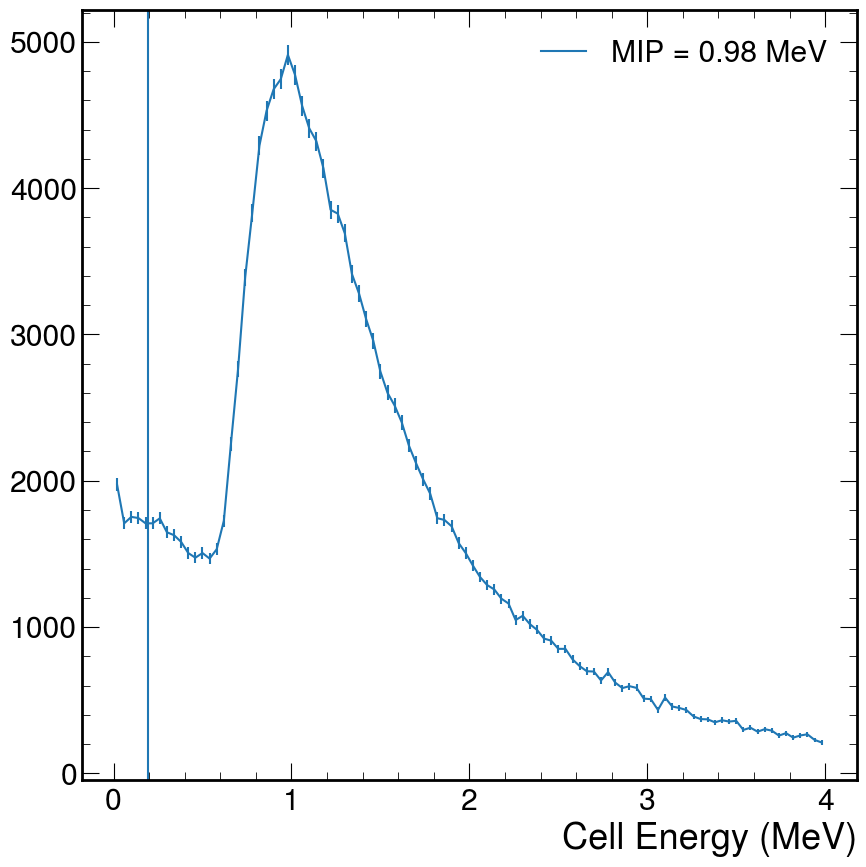

In [3]:
y,x=np.histogram(ak.flatten(arrays['muon']["MuographyHits.energy"]), bins=100, range=(0, 0.004))
bc=(x[1:]+x[:-1])/2
MIP=list(bc[y==max(y)])[0] 
plt.errorbar(np.array(bc)*1000,np.array(y),yerr=np.sqrt(y))
plt.axvline(0.2*MIP*1000,label=f'MIP = {MIP*1000:.2f} MeV')
plt.xlabel('Cell Energy (MeV)')
plt.legend()

In [10]:
data_energy = arrays['muon'][f'MuographyHits.energy']

sigma = 0.56

# flatten to numpy
flat = ak.to_numpy(data_energy.layout.content)
noise = np.random.normal(0, sigma, size=len(flat))*MIP

# add noise
flat_smear = flat + noise

# rebuild jagged array
offsets = ak.to_numpy(data_energy.layout.offsets)  # convert Index64 → numpy
lengths = offsets[1:] - offsets[:-1]
data_energy_smear = ak.unflatten(flat_smear, lengths)

data_MIP_cut = data_energy_smear > 0.2*MIP
data_cell_cut = [True if len(cells)>=2 else False for cells in arrays['muon'][f"MuographyHits.energy"][data_MIP_cut]]

data_x = arrays['muon'][f'MuographyHits.position.x'][np.array(data_cell_cut)]
data_y = arrays['muon'][f'MuographyHits.position.y'][np.array(data_cell_cut)]
data_z = arrays['muon'][f'MuographyHits.position.z'][np.array(data_cell_cut)]    
reco_data_angle = np.array([vector_angle_reconstruct(np.array(xi,dtype=float), np.array(yi,dtype=float), np.array(zi,dtype=float)) for xi, yi, zi in zip(data_x,data_y,data_z)])
status = arrays['muon']["MCParticles.generatorStatus"]
mc_px = arrays['muon']["MCParticles.momentum.x"][status==1][np.array(data_cell_cut)]
mc_py = arrays['muon']["MCParticles.momentum.y"][status==1][np.array(data_cell_cut)]
mc_pz = arrays['muon']["MCParticles.momentum.z"][status==1][np.array(data_cell_cut)]
mc_theta = theta_reconstruct(mc_px,mc_py,mc_pz)
mc_phi = phi_reconstruct(mc_px,mc_py,mc_pz)
mc_x = arrays['muon']["MCParticles.vertex.x"][status==1][np.array(data_cell_cut)]
mc_y = arrays['muon']["MCParticles.vertex.y"][status==1][np.array(data_cell_cut)]
mc_z = arrays['muon']["MCParticles.vertex.z"][status==1][np.array(data_cell_cut)]
data_energy_sum = [sum(cells)*1000 if len(cells)>=2 else False for cells in data_energy_smear[data_MIP_cut]]

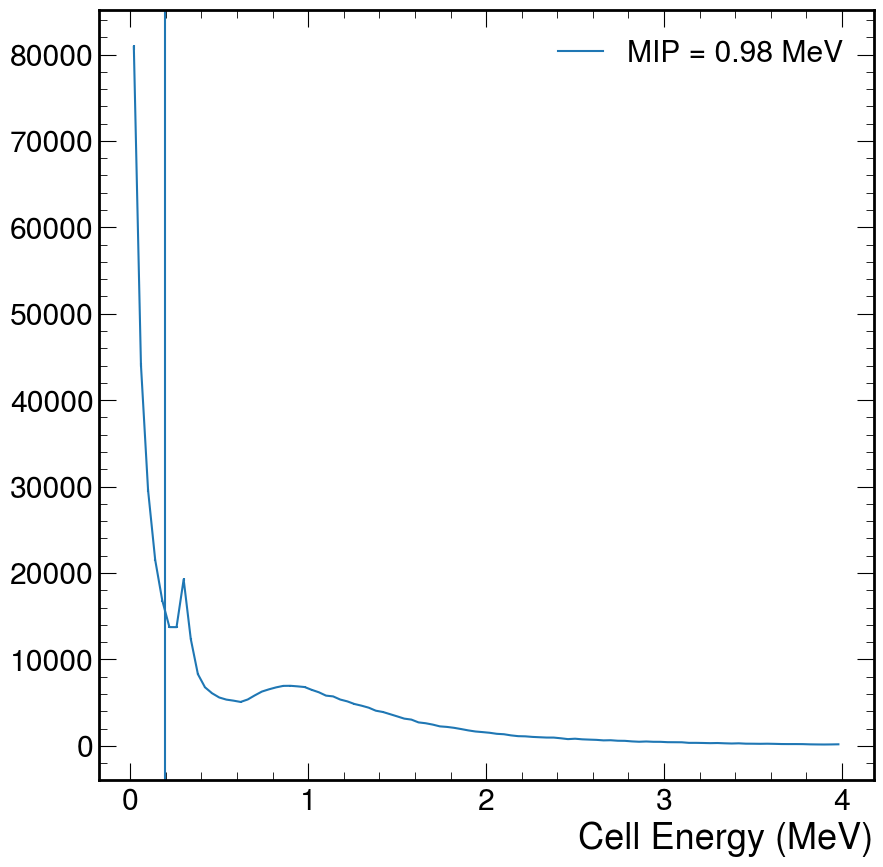

In [5]:
y,x=np.histogram(ak.flatten(arrays['muonss']["HcalFarForwardZDCHitsContributions.energy"]), bins=100, range=(0, 0.004))
bc=(x[1:]+x[:-1])/2
__MIP=list(bc[y==max(y)])[0] 
plt.errorbar(np.array(bc)*1000,np.array(y),yerr=np.sqrt(y))
plt.axvline(0.2*MIP*1000,label=f'MIP = {MIP*1000:.2f} MeV')
plt.xlabel('Cell Energy (MeV)')
plt.legend()

In [6]:
__data_energy = arrays['muonss'][f'HcalFarForwardZDCHits.energy']
__data_MIP_cut = __data_energy > 0.2*__MIP
__data_cell_cut = [True if len(cells)>=2 else False for cells in arrays['muonss'][f"HcalFarForwardZDCHits.energy"][__data_MIP_cut]]
__data_x = arrays['muonss'][f'HcalFarForwardZDCHits.position.x'][np.array(__data_cell_cut)]
__data_y = arrays['muonss'][f'HcalFarForwardZDCHits.position.y'][np.array(__data_cell_cut)]
__data_z = arrays['muonss'][f'HcalFarForwardZDCHits.position.z'][np.array(__data_cell_cut)]    
__reco_data_angle = np.array([vector_angle_reconstruct(np.array(xi,dtype=float), np.array(yi,dtype=float), np.array(zi,dtype=float)) for xi, yi, zi in zip(__data_x,__data_y,__data_z)])
__status = arrays['muonss']["MCParticles.generatorStatus"]
__mc_px = arrays['muonss']["MCParticles.momentum.x"][__status==1][np.array(__data_cell_cut)]
__mc_py = arrays['muonss']["MCParticles.momentum.y"][__status==1][np.array(__data_cell_cut)]
__mc_pz = arrays['muonss']["MCParticles.momentum.z"][__status==1][np.array(__data_cell_cut)]
__mc_theta = theta_reconstruct(__mc_px,__mc_py,__mc_pz)
__mc_phi = phi_reconstruct(__mc_px,__mc_py,__mc_pz)
__mc_x = arrays['muonss']["MCParticles.vertex.x"][__status==1][np.array(__data_cell_cut)]
__mc_y = arrays['muonss']["MCParticles.vertex.y"][__status==1][np.array(__data_cell_cut)]
__mc_z = arrays['muonss']["MCParticles.vertex.z"][__status==1][np.array(__data_cell_cut)]

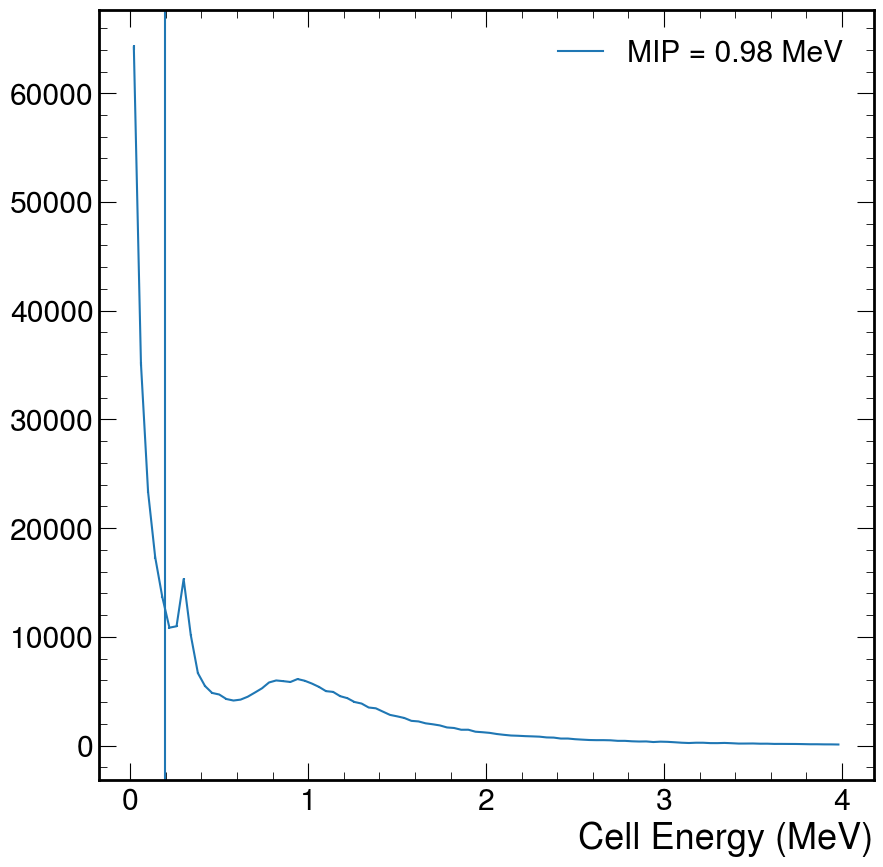

In [7]:
y,x=np.histogram(ak.flatten(arrays['muons']["HcalFarForwardZDCHitsContributions.energy"]), bins=100, range=(0, 0.004))
bc=(x[1:]+x[:-1])/2
_MIP=list(bc[y==max(y)])[0] 
plt.errorbar(np.array(bc)*1000,np.array(y),yerr=np.sqrt(y))
plt.axvline(0.2*MIP*1000,label=f'MIP = {MIP*1000:.2f} MeV')
plt.xlabel('Cell Energy (MeV)')
plt.legend()

In [8]:
_data_energy = arrays['muons'][f'HcalFarForwardZDCHits.energy']
_data_MIP_cut = _data_energy > 0.2*_MIP
_data_cell_cut = [True if len(cells)>=2 else False for cells in arrays['muons'][f"HcalFarForwardZDCHits.energy"][_data_MIP_cut]]
_data_x = arrays['muons'][f'HcalFarForwardZDCHits.position.x'][np.array(_data_cell_cut)]
_data_y = arrays['muons'][f'HcalFarForwardZDCHits.position.y'][np.array(_data_cell_cut)]
_data_z = arrays['muons'][f'HcalFarForwardZDCHits.position.z'][np.array(_data_cell_cut)]    
_reco_data_angle = np.array([vector_angle_reconstruct(np.array(xi,dtype=float), np.array(yi,dtype=float), np.array(zi,dtype=float)) for xi, yi, zi in zip(_data_x,_data_y,_data_z)])
_status = arrays['muons']["MCParticles.generatorStatus"]
_mc_px = arrays['muons']["MCParticles.momentum.x"][_status==1][np.array(_data_cell_cut)]
_mc_py = arrays['muons']["MCParticles.momentum.y"][_status==1][np.array(_data_cell_cut)]
_mc_pz = arrays['muons']["MCParticles.momentum.z"][_status==1][np.array(_data_cell_cut)]
_mc_theta = theta_reconstruct(_mc_px,_mc_py,_mc_pz)
_mc_phi = phi_reconstruct(_mc_px,_mc_py,_mc_pz)
_mc_x = arrays['muons']["MCParticles.vertex.x"][_status==1][np.array(_data_cell_cut)]
_mc_y = arrays['muons']["MCParticles.vertex.y"][_status==1][np.array(_data_cell_cut)]
_mc_z = arrays['muons']["MCParticles.vertex.z"][_status==1][np.array(_data_cell_cut)]

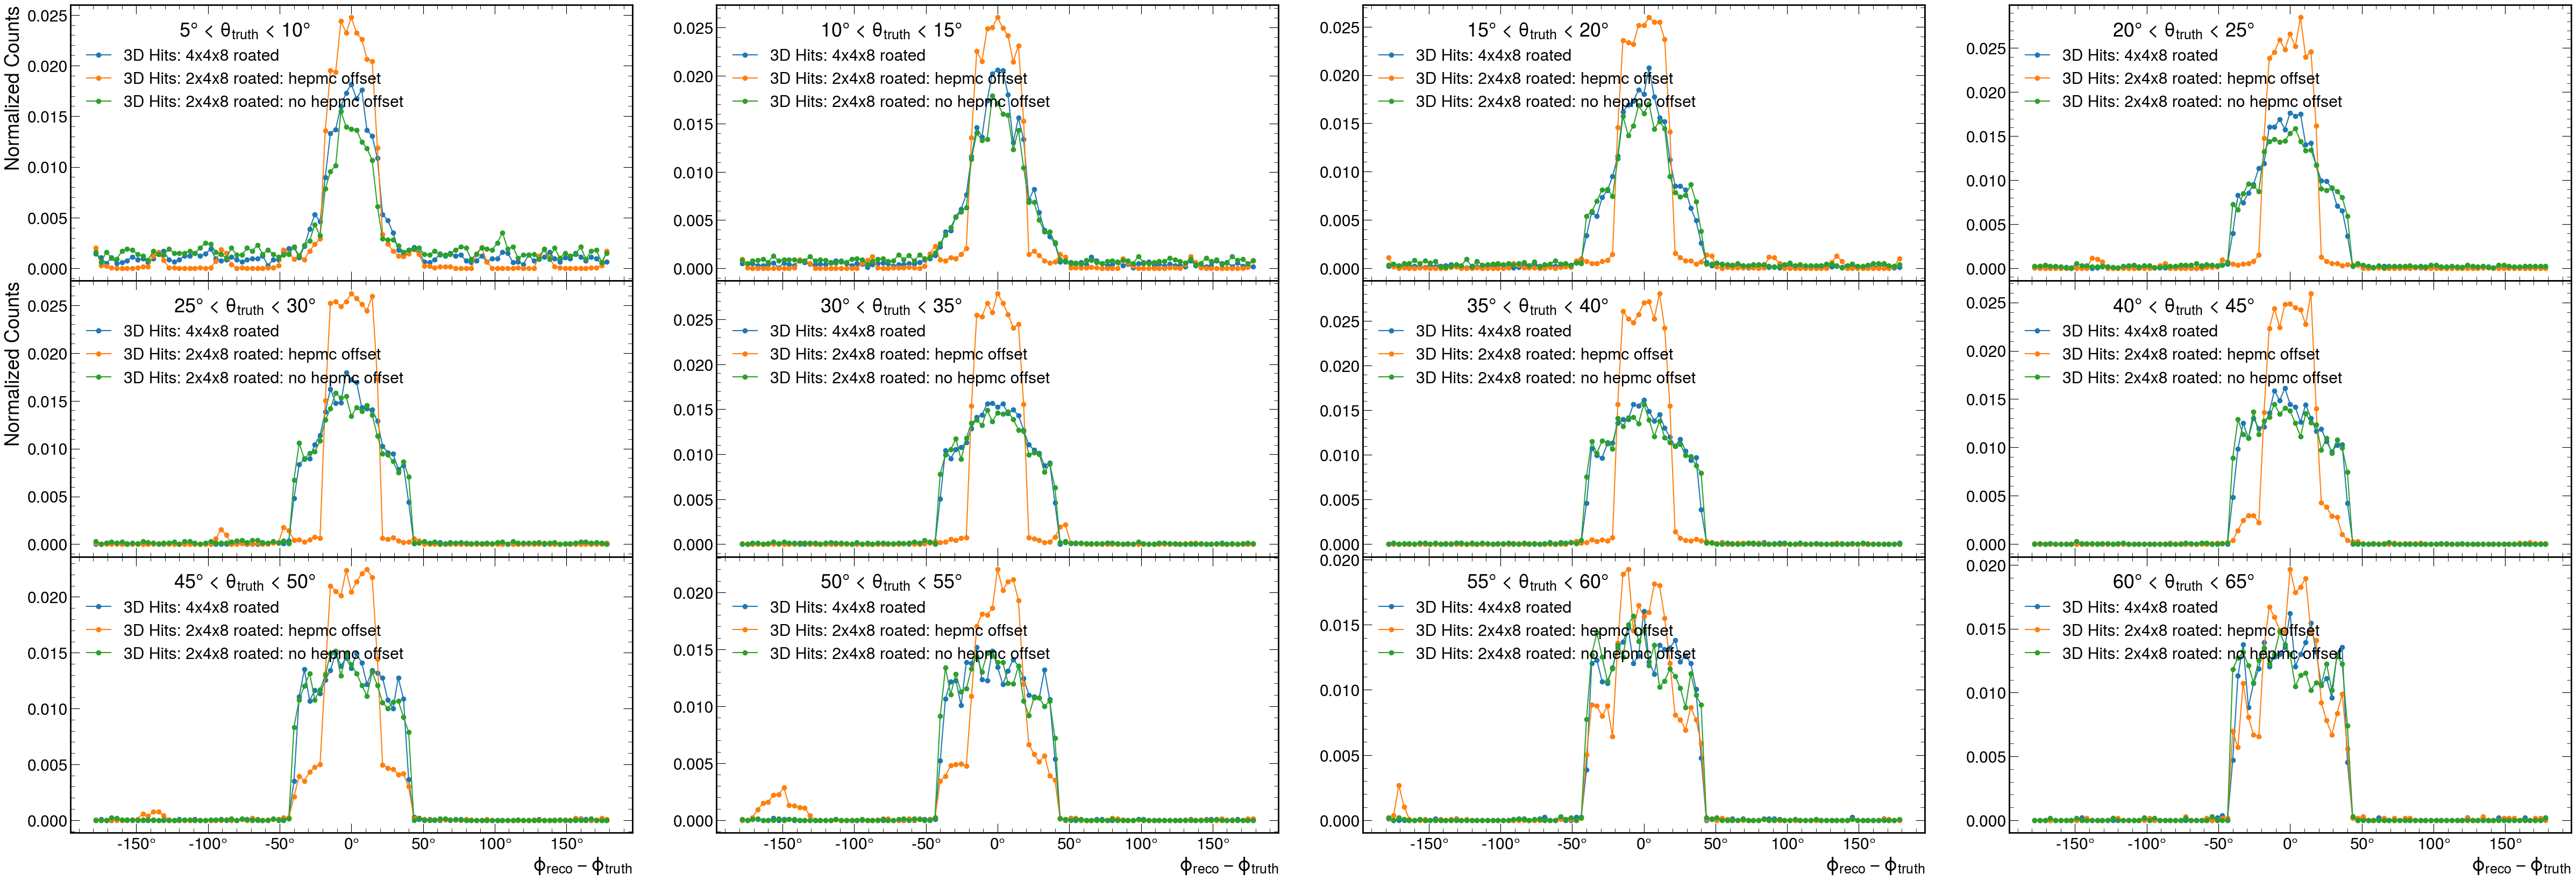

In [11]:
binsize = 5
binnum = np.linspace(-180,180,100)
max_bin = 65
fig, ax = plt.subplots(3,4,figsize=(60,20),sharex=True,sharey=False)
#plt.suptitle('Square Offset 4x16 Detector',fontsize=60)
for i in range(12):
    plt.sca(ax[i//4,i%4])
    cut = (((i) * binsize+5 <= np.array(np.concatenate(mc_theta))) & (np.array(np.concatenate(mc_theta)) < (i+1) * binsize+5))
    y,x = np.histogram(reco_data_angle[:,1][cut]-mc_phi[cut],bins=binnum,density=True)
    bc=(x[1:]+x[:-1])/2
    plt.errorbar(bc,y, fmt='-o',label='3D Hits: 4x4x8 roated')

    cut = (((i) * binsize+5 <= np.array(np.concatenate(__mc_theta))) & (np.array(np.concatenate(__mc_theta)) < (i+1) * binsize+5))
    y,x = np.histogram(__reco_data_angle[:,1][cut]-__mc_phi[cut],bins=binnum,density=True)
    bc=(x[1:]+x[:-1])/2
    plt.errorbar(bc,y, fmt='-o',label='3D Hits: 2x4x8 roated: hepmc offset')

    cut = (((i) * binsize+5 <= np.array(np.concatenate(_mc_theta))) & (np.array(np.concatenate(_mc_theta)) < (i+1) * binsize+5))
    y,x = np.histogram(_reco_data_angle[:,1][cut]-_mc_phi[cut],bins=binnum,density=True)
    bc=(x[1:]+x[:-1])/2
    plt.errorbar(bc,y, fmt='-o',label='3D Hits: 2x4x8 roated: no hepmc offset')

    plt.xlabel(r'$\phi_{reco} - \phi_{truth}$')
    plt.legend(title=rf'{i * binsize+5}$\degree$ < $\theta_{{truth}}$ < {(i+1) * binsize+5}$\degree$', loc = 'upper left')
    #plt.xlim(-50,50)
fig.subplots_adjust(wspace=0.15,hspace=0)

ax[0,0].set_ylabel('Normalized Counts')
ax[1,0].set_ylabel('Normalized Counts')
#ax[2,0].set_ylabel('Normalized Counts')

import matplotlib.ticker as mticker
def degree_formatter(x, pos):
    return rf"{int(x)}$\degree$" 
for axi in ax.flat:
    axi.xaxis.set_major_formatter(mticker.FuncFormatter(degree_formatter))

#plt.savefig('ThetaResolution_differential.pdf',format='pdf')

Fit parameters: A=11.325, k=0.067, C=1.615


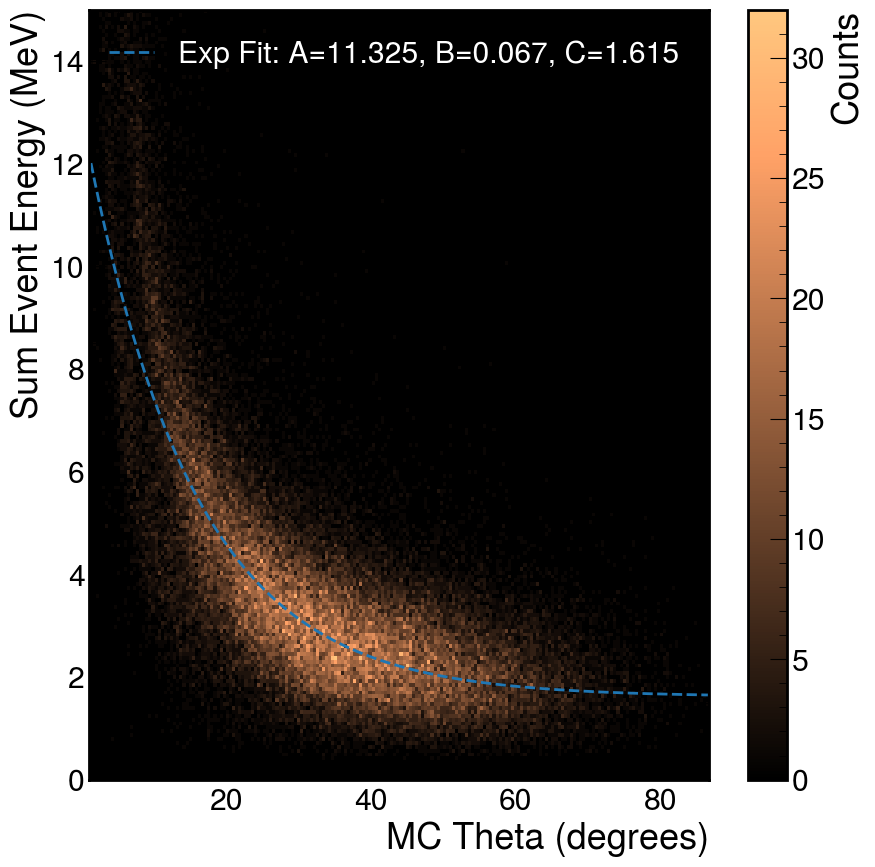

In [12]:
H, xedges, yedges = np.histogram2d(
    np.array(np.concatenate(mc_theta)),
    np.array(data_energy_sum)[np.array(data_cell_cut)],
    bins=(200, np.linspace(0,15,200))
)

X, Y = np.meshgrid(xedges, yedges)

plt.pcolormesh(X, Y, H.T, cmap="copper")
plt.colorbar(label='Counts')
plt.xlabel("MC Theta (degrees)")
plt.ylabel('Sum Event Energy (MeV)')
#plt.yscale('log')


peak_indices = np.argmax(H, axis=1)
theta_centers = 0.5 * (xedges[:-1] + xedges[1:])
energy_centers = 0.5 * (yedges[:-1] + yedges[1:])
E_peaks = energy_centers[peak_indices]
def exp_decay(theta, A, k, C):
    return A * np.exp(-k * theta) + C
# Remove NaNs or weird edges
mask = np.isfinite(E_peaks)
theta_fit = theta_centers[mask]
E_fit = E_peaks[mask]

popt, pcov = curve_fit(exp_decay, theta_fit, E_fit, p0=(10, 0.05, 0))
A, k, C = popt
print("Fit parameters: A=%.3f, k=%.3f, C=%.3f" % (A, k, C))
theta_smooth = np.linspace(theta_fit.min(), theta_fit.max(), 300)
plt.plot(theta_smooth, exp_decay(theta_smooth, *popt), '--', lw=2, label="Exp Fit: A=%.3f, B=%.3f, C=%.3f" % (A, k, C))
legend = plt.legend(facecolor="black", edgecolor="white")
for text in legend.get_texts():
    text.set_color("white")

/tmp/ipykernel_3008598/2598758279.py:2: RuntimeWarning: invalid value encountered in log
  return -(1.0 / k) * np.log((E - C) / A)


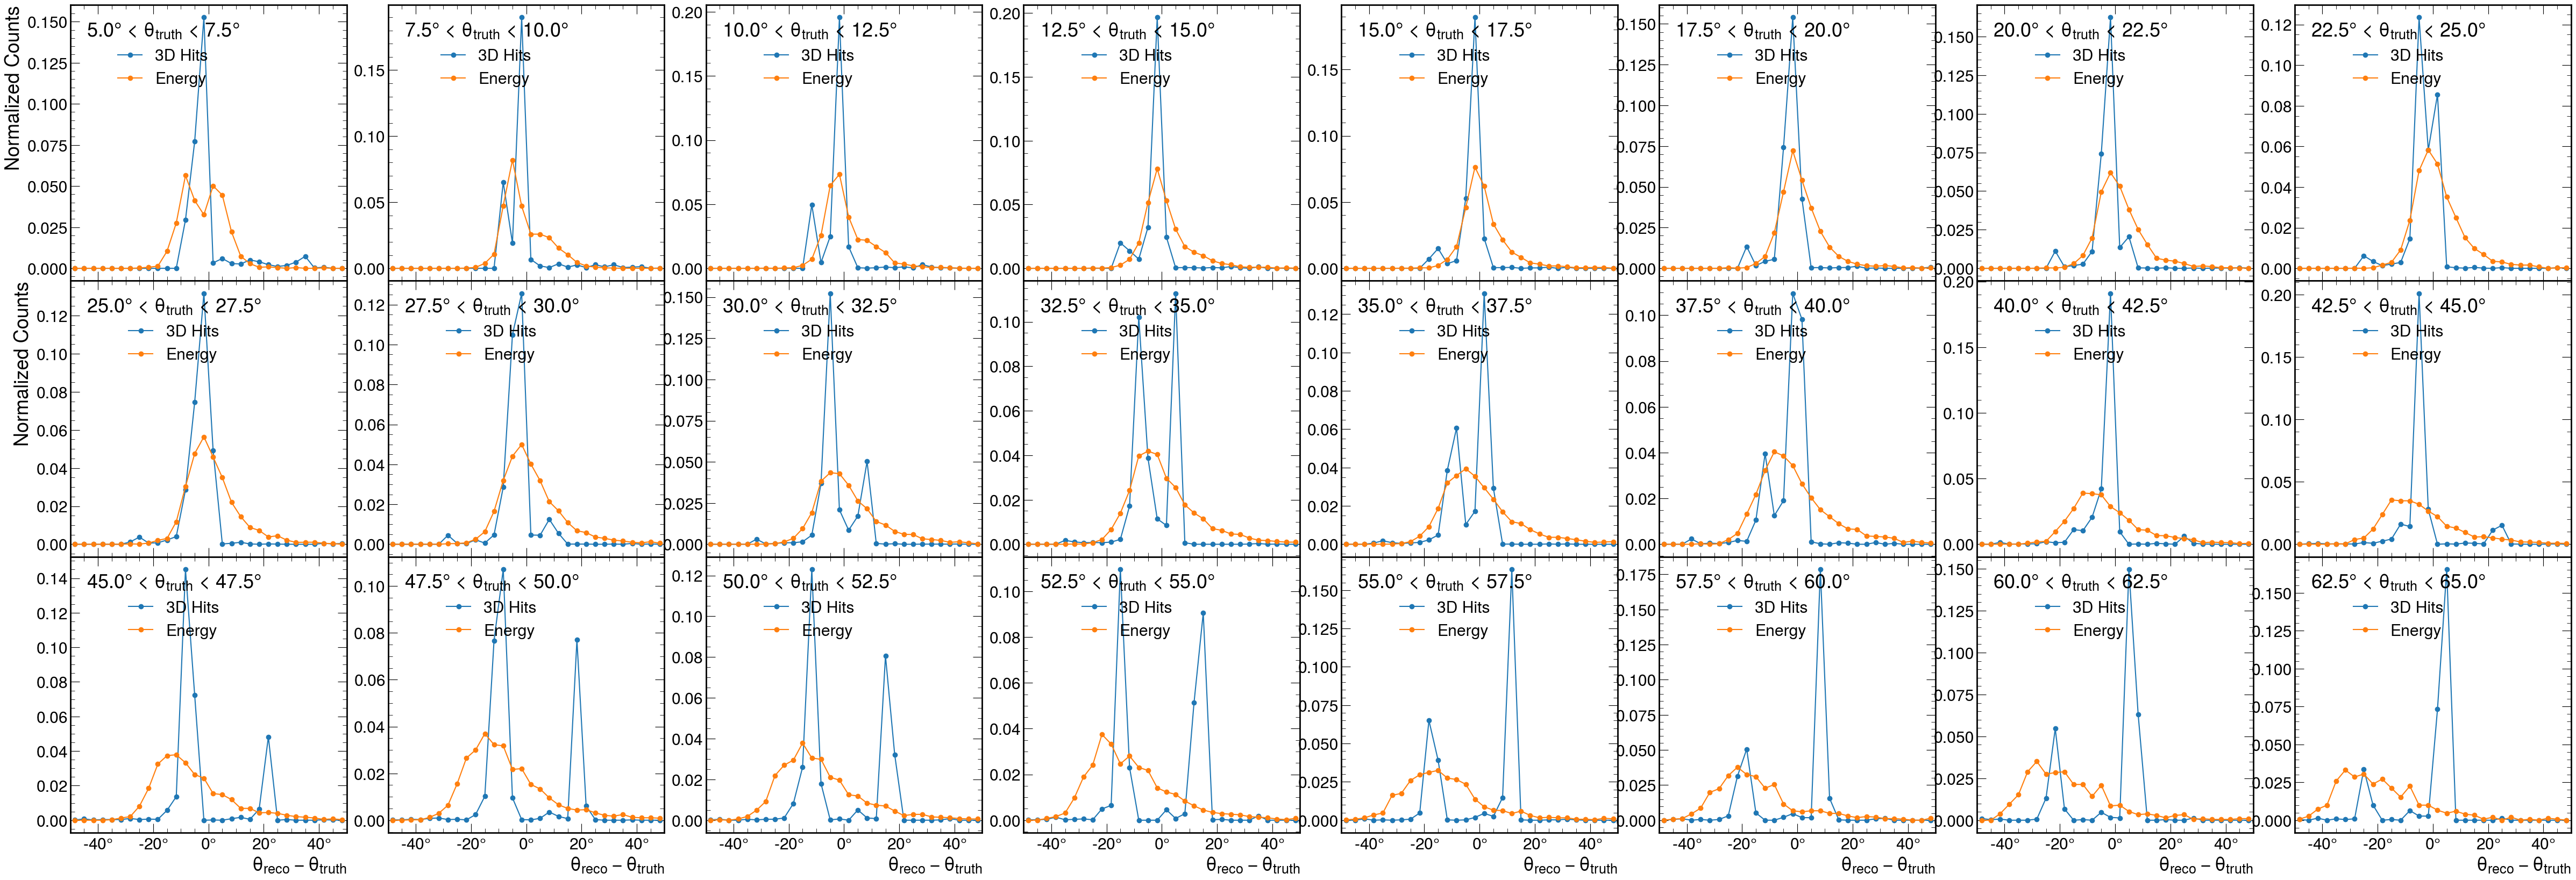

In [13]:
def theta_from_energy(E, A, k, C):
    return -(1.0 / k) * np.log((E - C) / A)
    
binsize = 2.5
bin = []
rms = []
mea = []
fits = []
binnum = 30
max_bin = 65
fig, ax = plt.subplots(3,8,figsize=(60,20),sharex=True,sharey=False)
#plt.suptitle('Square Offset 4x16 Detector',fontsize=60)
for i in range(24):
    plt.sca(ax[i//8,i%8])
    bin.append(i*binsize+5+binsize/2)
    cut = (((i) * binsize + 5 <= np.array(np.concatenate(mc_theta))) & (np.array(np.concatenate(mc_theta)) < (i+1) * binsize + 5))
    y,x = np.histogram(reco_data_angle[:,0][cut]-mc_theta[cut],bins=binnum,range=(-50,50),density=True)
    bc=(x[1:]+x[:-1])/2
    plt.errorbar(bc,y, fmt='-o',label='3D Hits')
    means = np.array(reco_data_angle[:,0][cut]-mc_theta[cut])
    rms.append(np.std(means))
    mea.append(np.mean(means))
    coeff, _ = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,100))
    fits.append(coeff)
    #x=np.linspace(-50,50,100)
    #plt.errorbar(x,gaus(x,*coeff),fmt='--',label='3D Hits Fit')
    
    y,x = np.histogram(theta_from_energy(np.array(data_energy_sum)[np.array(data_cell_cut)],*popt)[cut]-mc_theta[cut],bins=binnum,range=(-50,50),density=True)
    bc=(x[1:]+x[:-1])/2
    plt.errorbar(bc,y, fmt='-o',label=rf'Energy')
    means = np.array(theta_from_energy(np.array(data_energy_sum)[np.array(data_cell_cut)],*popt)[cut]-mc_theta[cut])
    rms.append(np.nanstd(means))
    mea.append(np.nanmean(means))
    coeff, _ = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,10))
    fits.append(coeff)
    #x=np.linspace(-50,50,100)
    #plt.errorbar(x,gaus(x,*coeff),fmt='--',label='Energy Fit')

    plt.xlabel(r'$\theta_{reco} - \theta_{truth}$')
    plt.legend(title=rf'{i * binsize+5}$\degree$ < $\theta_{{truth}}$ < {(i+1) * binsize+5}$\degree$', loc = 'upper left')
    plt.xlim(-50,50)
fig.subplots_adjust(wspace=0.15,hspace=0)

ax[0,0].set_ylabel('Normalized Counts')
ax[1,0].set_ylabel('Normalized Counts')
#ax[2,0].set_ylabel('Normalized Counts')

import matplotlib.ticker as mticker
def degree_formatter(x, pos):
    return rf"{int(x)}$\degree$" 
for axi in ax.flat:
    axi.xaxis.set_major_formatter(mticker.FuncFormatter(degree_formatter))

plt.savefig('ThetaResolution_differential.pdf',format='pdf')

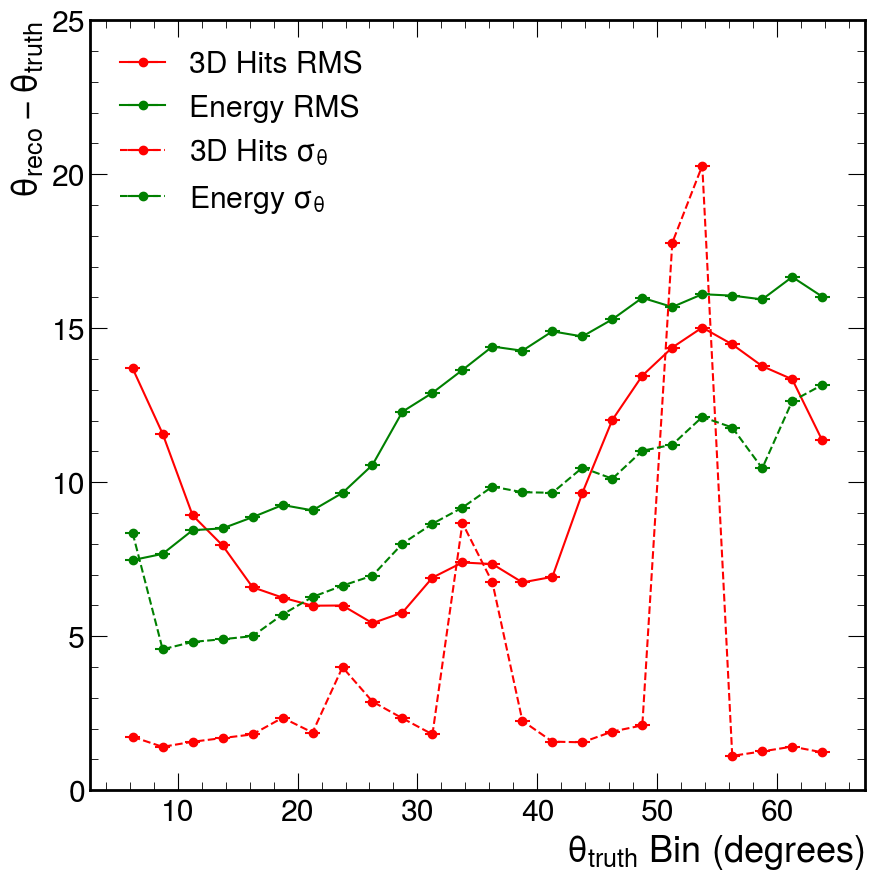

In [14]:
plt.errorbar(bin,rms[::2],xerr=(bin[1]-bin[0])/4,label='3D Hits RMS',fmt='-o',c='r')
plt.errorbar(bin,rms[1::2],xerr=(bin[1]-bin[0])/4,label='Energy RMS',fmt='-o',c='g')
plt.errorbar(bin,abs(np.array(fits)[:,2][::2]),xerr=(bin[1]-bin[0])/4,label=r'3D Hits $\sigma_{\theta}$',fmt='--o',c='r')
plt.errorbar(bin,abs(np.array(fits)[:,2][1::2]),xerr=(bin[1]-bin[0])/4,label=r'Energy $\sigma_{\theta}$',fmt='--o',c='g')
plt.xlabel(rf'$\theta_{{truth}}$ Bin (degrees)')
plt.ylabel(r'$\theta_{reco} - \theta_{truth}$')
plt.ylim(bottom=0,top=25)
plt.legend()

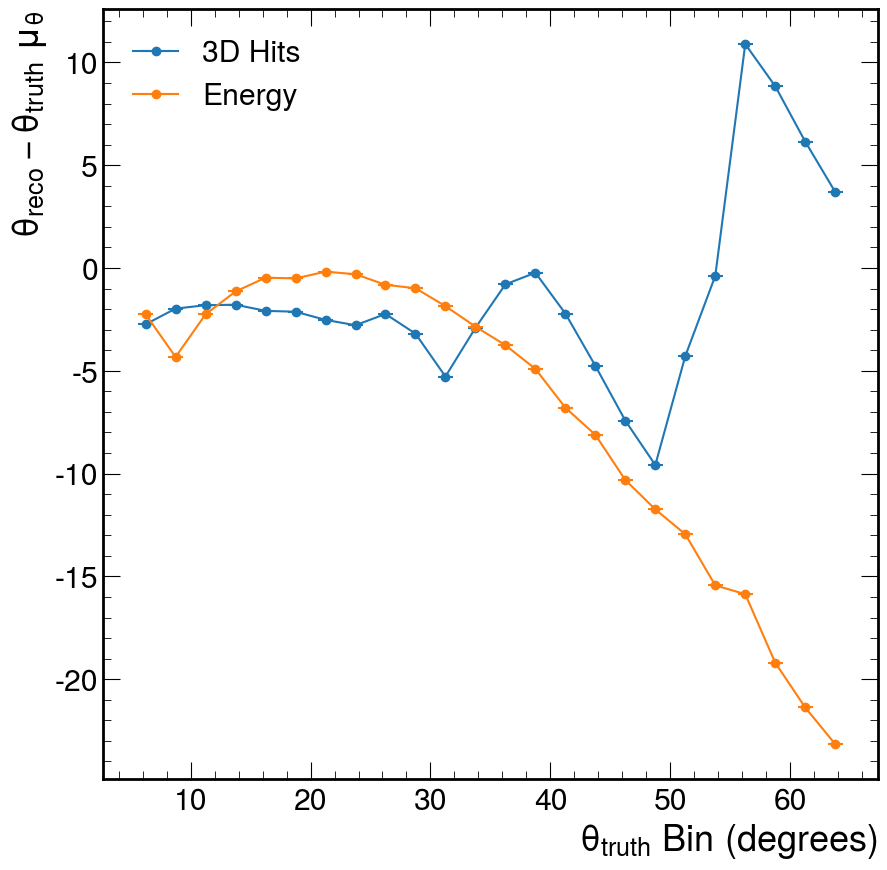

In [15]:
plt.errorbar(bin,np.array(fits)[:,1][::2],xerr=(bin[1]-bin[0])/4,label='3D Hits',fmt='-o')
plt.errorbar(bin,np.array(fits)[:,1][1::2],xerr=(bin[1]-bin[0])/4,label='Energy',fmt='-o')
plt.xlabel(rf'$\theta_{{truth}}$ Bin (degrees)')
plt.ylabel(r'$\theta_{reco} - \theta_{truth}$ $\mu_{\theta}$')
#plt.ylim(bottom=0)
plt.legend()

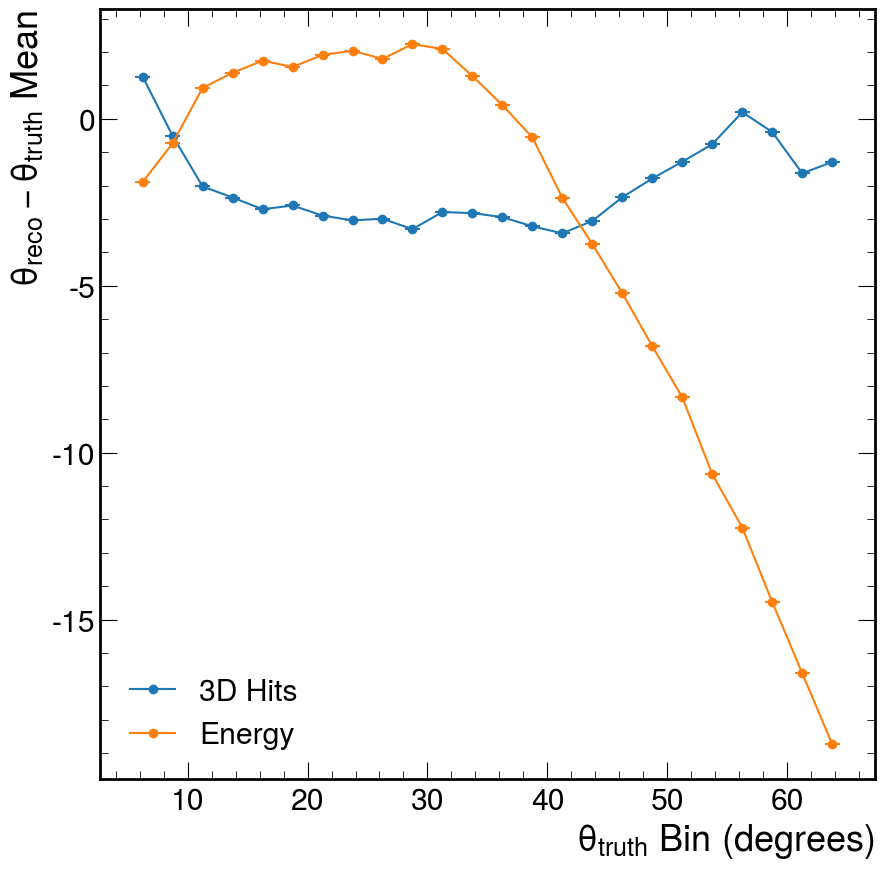

In [16]:
plt.errorbar(bin,mea[::2],xerr=(bin[1]-bin[0])/4,label='3D Hits',fmt='-o')
plt.errorbar(bin,mea[1::2],xerr=(bin[1]-bin[0])/4,label='Energy',fmt='-o')
plt.xlabel(rf'$\theta_{{truth}}$ Bin (degrees)')
plt.ylabel(r'$\theta_{reco} - \theta_{truth}$ Mean')
plt.legend()